Import dependencies

In [4]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hopsworks

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/197788
Connected. Call `.close()` to terminate connection gracefully.


Fetch the data

In [5]:
wine_quality = fetch_ucirepo(id=186) 

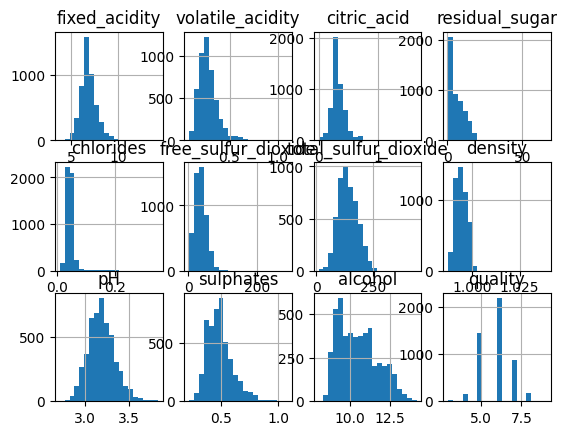

In [6]:
def visualize_dataset(features, targets, columns):
    fig, axis = plt.subplots(3, 4)
    c = 0
    for i in range(3):
        for j in range(4):
            if c == 11:
                break
            axis[i,j].title.set_text(columns[c])
            features[columns[c]].hist(bins = 20, ax = axis[i,j])
            c += 1
    axis[2,3].title.set_text("quality")
    targets["quality"].hist(bins = 20, ax = axis[2,3])
    plt.show()

columns = wine_quality.data.features.columns
visualize_dataset(wine_quality.data.features, wine_quality.data.targets, columns)

In [7]:
df_features = wine_quality.data.features

drop_col = ["fixed_acidity",
           "citric_acid",
           "total_sulfur_dioxide",
           "density",
           "pH",
           "sulphates",
           ]

df_features.drop(columns = drop_col, inplace = True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
columns = [
           "volatile_acidity",
           "residual_sugar",
           "chlorides",
           "free_sulfur_dioxide",
           "alcohol",
           "quality"
           ]

X = df_features
v = wine_quality.data.targets.values.squeeze()
v1 = np.select([v<6,v==6, v>6],[0,1,2])[:,None]
y = pd.DataFrame(v1, columns=["quality"])

X = pd.concat([X, y], axis = 1)

wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    primary_key=columns, 
    description="Dataset containing properties of different white wines and their respective qualities")
wine_fg.insert(X)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/197788/fs/197707/fg/210259


Uploading Dataframe: 100.00% |██████████| Rows 4898/4898 | Elapsed Time: 00:05 | Remaining Time: 00:00


Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/197788/jobs/named/wine_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fed049772e0>, None)